In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
import numpy as np
import sys
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import tensorflow as tf
# from sklearn.preprocessing import MinMaxScaler
from sortedcontainers import SortedList

/nfs_home/nbhardwaj/.local/lib/python2.7/site-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [2]:
def split_sequence(sequence, n_steps):
        X, y = list(), list()
        for i in range(len(sequence)):
                end_ix = i + n_steps
                if end_ix > len(sequence)-1:
                        break
                seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
                X.append(seq_x)
                y.append(seq_y)
        return np.array(X), np.array(y)

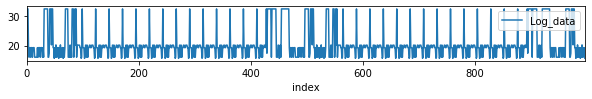

898 100


In [24]:
#File address
# ADDR = '/nfs_home/SPEC_2006/400.perlbench/400.perlbench.pinatrace.csv'
ADDR = './400part2.csv'
# ADDR = sys.argv[1:]
df = pd.read_csv(ADDR, skiprows = [0])
df.drop('ICount', axis = 1, inplace = True)

#Pre-processing
df['Instruction_int'] = df.Instruction.apply(lambda x:int(x,16))
df['Data_int'] = df.Data.apply(lambda x:int(x, 16))
df['Log_data'] = np.log(df['Data_int'])

df.reset_index(inplace = True)

# print(df[['index', 'Instruction_int', 'Data_int', 'Mode', 'Log_data']])


df.plot(x = 'index', y = 'Log_data', kind = 'line', figsize = (10,1))

train, test = df[:-100], df[-100:]


# print(df)
pyplot.show()
print(len(train), len(test))

   index Instruction Mode            Data  Instruction_int         Data_int  \
0      0    0x4888cd    W  0x7ffd629f37c8          4753613  140726258055112   
1      1    0x484230    W  0x7ffd629f37c0          4735536  140726258055104   
2      2    0x484234    W  0x7ffd629f37b8          4735540  140726258055096   
3      3    0x48423c    R       0xde8b11d          4735548        233353501   
4      4    0x484252    R        0x85f138          4735570          8778040   

    Log_data  
0  32.577838  
1  32.577838  
2  32.577838  
3  19.268065  
4  15.987764  


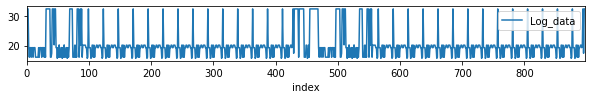

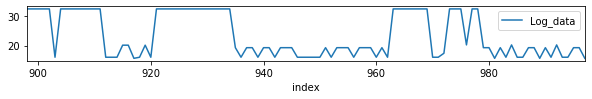

In [25]:
train.plot(x = 'index', y = 'Log_data', kind = 'line', figsize = (10,1))
print(train.head())
test.plot(x = 'index', y = 'Log_data', kind = 'line', figsize = (10,1))


In [26]:
# train = train.reshape((-1,1))
# test = test.reshape((-1,1))

In [27]:

# scaler = MinMaxScaler(feature_range=(-1, 1))
# train = scaler.fit_transform(train)
# test = scaler.transform(test)

In [28]:
n_steps = 20
X, y = split_sequence(train['Log_data'], n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
print("X.shape = {}".format(X.shape))
print("y.shape = {}".format(y.shape))

X.shape = (878, 20, 1)
y.shape = (878,)


In [29]:
model = Sequential()
model.add(LSTM(100, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(optimizer='adam', loss='mse')

Train on 878 samples
Epoch 1/100
878/878 [==============================] - 1s 1ms/sample - loss: 34.7771
Epoch 2/100
878/878 [==============================] - 0s 401us/sample - loss: 22.0533
Epoch 3/100
878/878 [==============================] - 0s 412us/sample - loss: 20.3544
Epoch 4/100
878/878 [==============================] - 0s 381us/sample - loss: 20.7960
Epoch 5/100
878/878 [==============================] - 0s 388us/sample - loss: 19.3940
Epoch 6/100
878/878 [==============================] - 0s 387us/sample - loss: 18.8226
Epoch 7/100
878/878 [==============================] - 0s 393us/sample - loss: 19.3690
Epoch 8/100
878/878 [==============================] - 0s 405us/sample - loss: 19.0969
Epoch 9/100
878/878 [==============================] - 0s 392us/sample - loss: 18.6135
Epoch 10/100
878/878 [==============================] - 0s 401us/sample - loss: 19.3999
Epoch 11/100
878/878 [==============================] - 0s 385us/sample - loss: 18.3442
Epoch 12/100
878/878 [

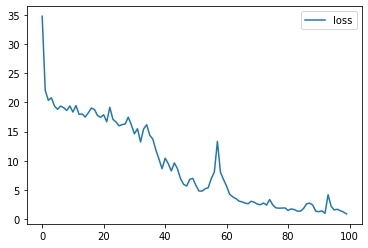

In [30]:
history = model.fit(X, y, epochs=100, verbose=1, use_multiprocessing=True)
plt.plot(history.history['loss'], label="loss")
plt.legend(loc="upper right")
plt.show()

### Save the weights 

In [34]:
model.save("model_without_scaling.h5")


### Load back the weights

In [3]:
model = tf.keras.models.load_model("model_without_scaling.h5")
#File address
# ADDR = '/nfs_home/SPEC_2006/400.perlbench/400.perlbench.pinatrace.csv'
ADDR = './400part2.csv'
# ADDR = sys.argv[1:]
df = pd.read_csv(ADDR, skiprows = [0])
df.drop('ICount', axis = 1, inplace = True)

#Pre-processing
df['Instruction_int'] = df.Instruction.apply(lambda x:int(x,16))
df['Data_int'] = df.Data.apply(lambda x:int(x, 16))
df['Log_data'] = np.log(df['Data_int'])

df.reset_index(inplace = True)
train, test = df[:-100], df[-100:]

n_steps = 20
X, y = split_sequence(train['Log_data'].values, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
print("X.shape = {}".format(X.shape))
print("y.shape = {}".format(y.shape))

X.shape = (878, 20, 1)
y.shape = (878,)


## Prediction using real values in the sliding window

In [4]:

# start with initial n values, rest will be predicted

pred_y = df['Log_data'].values[:n_steps] # initial_sequence
act_y = df['Log_data'].values # ground truth
test_xaxis = df['index'].values

for i in range( len(test_xaxis) - n_steps ):
    net_input = act_y[i : i + n_steps]
    net_input = net_input.reshape((1, n_steps, n_features))
    y = model.predict(net_input, verbose=0)
#     out_y = scaler.inverse_transform(y)
    pred_y = np.append(pred_y, y)

# plt.ylim(-2, 2)
# plt.show()

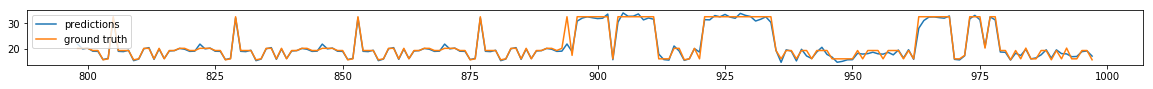

In [5]:

plt.figure(figsize = (20,1))
plt.plot(test_xaxis[-200:], pred_y[-200:], label="predictions")
plt.plot(test_xaxis[-200:], act_y[-200:], label="ground truth")
# plt.plot(test_xaxis[:n_steps], act_y[:n_steps], label="initial sequence", color="red")
plt.legend(loc='upper left')

In [6]:
diff = pred_y[-100:] - act_y[-100:]

print(diff)

[-0.01670335 -0.40291856 -0.72524331 -0.57788156  1.05795791 -0.34455773
 -2.14922212  1.50764586  0.16836669  0.20970656  1.10067107 -1.23841928
 -0.4993007  -0.9789531   1.87785438 -0.30027244 -0.49093053  0.92674211
 -1.03702018 -0.21896963  0.02266219 -0.12182279  2.65647033 -1.14860223
 -1.23591493  0.46992995 -0.02683518  0.91085936 -0.14354203 -0.60428689
  1.3199742   0.53687789  0.09277465 -1.690747   -0.99345277 -0.03864167
 -2.21028207  0.03915352 -1.37648803  0.27108179 -0.23118149 -0.81358158
  0.49022852 -2.15051317  0.13406682 -0.58460253  1.26772449 -1.53729299
  0.68292058 -1.34954796 -0.99388801 -0.37407712 -0.32861335 -1.10020842
  1.87507888 -1.23435261 -0.66451776 -1.28555176  1.84322997 -0.72681095
 -1.70529689  0.18231131  0.30942794  0.31785915 -0.18733117 -4.54681657
 -1.49208901 -0.12334703 -0.06841157 -0.34951661 -0.5669658   0.30060317
 -0.20472633 -0.41554874 -0.16781953 -0.81277726  0.53907515 -1.1914737
  0.43765609 -0.05798219 -1.2578666  -0.5865427  -0.

998


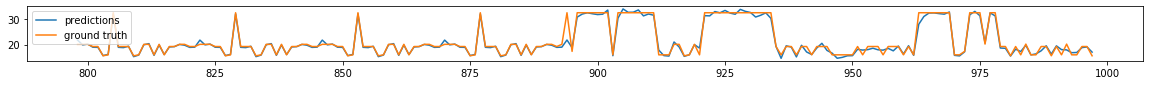

In [44]:

# start with initial n values, rest will be predicted
pred2_y = df['Log_data'].values[:n_steps]

sl = SortedList(act_y)
        
len_sl = len(sl)

print(len(sl))
for i in range( len(test_xaxis) - n_steps ):
    net_input = act_y[i : i + n_steps]
    net_input = net_input.reshape((1, n_steps, n_features))
    
    y = model.predict(net_input, verbose=0)
    min_pred = y
    
    if y not in sl:
        l_ind = (sl.bisect_left(y)-1)
        r_ind = (sl.bisect_right(y))
#         print(l_ind, r_ind)
        if(l_ind<0):
            min_pred = sl[0]
        elif (r_ind >= len_sl):
            min_pred = sl[len_sl-1]
        else:
            min_pred = min(abs(y - sl[l_ind]), abs(sl[r_ind]-y))
    pred2_y = np.append(pred_y, min_pred)
    
# plt.ylim(-2, 2)
# plt.show()


plt.figure(figsize = (20,1))
plt.plot(test_xaxis[-200:], pred_y[-200:], label="predictions")
plt.plot(test_xaxis[-200:], act_y[-200:], label="ground truth")
# plt.plot(test_xaxis[:n_steps], act_y[:n_steps], label="initial sequence", color="red")
plt.legend(loc='upper left')

In [45]:
diff = pred2_y[-100:] - act_y[-100:]

print(diff)

[ -0.40291856  -0.72524331  -0.57788156   1.05795791 -16.93472741
  14.44094756   1.50764586   0.16836669   0.20970656   1.10067107
  -1.23841928  -0.4993007   -0.9789531  -14.7123153   -0.29999539
  -0.49120757   5.06586936  -1.03702018  -4.73442981   0.39899511
   4.01730445  -1.48265691  15.44156745  -1.23591493   0.46992995
  -0.02683518   0.91085936  -0.14354203  -0.60428689   1.3199742
   0.53687789   0.09277465  -1.690747    -0.99345277  -0.03864167
  -2.21028207 -13.27061914  -4.65678936   3.55138272  -0.23151793
  -4.09348045   3.77046383  -2.15051283  -3.14623308   2.69569707
   1.26772482  -1.53729298  -2.59741262  -1.34922492  -0.99423656
  -0.37369166  -0.32883385   2.17998498  -1.40489401   2.04562064
  -0.66485455  -1.28616464  -1.43579361   2.5531623   -1.70563366
   0.18169842  -2.96959566   3.5978324   -3.46772816  12.04335311
  -1.49208901  -0.12334703  -0.06841157  -0.34951661  -0.5669658
   0.30060317 -16.7947347   -0.41533005   1.19604356  14.41314932
   0.5390751

#### Testing for SortedContainers

In [34]:
from sortedcontainers import SortedList

In [35]:
sl = SortedList()

In [36]:
for x in range(10):
    sl.add(x)

In [37]:
sl

SortedList([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [38]:
sl.bisect_left(2)

2

0

In [42]:
a = 0
a_l = sl[sl.bisect_left(a)]
a_r = sl[sl.bisect_right(a)]
print(a_l, a_r)

0 1
